##### Example use of the hyperopt to see the sensitivy of an algorith with respect ot their hyperparameters
Here the use-case is a RandomForest algo and see the importance of different hyperaparameters based on the accuracy on the train and test set.
Simple train/test split has been performed.

In [1]:
from __future__ import print_function

from pprint import pprint
from time import time
import logging
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

#############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80, 150),
}

X = data.data
y = data.target

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

#     print("Performing grid search...")
#     print("pipeline:", [name for name, _ in pipeline.steps])
#     print("parameters:")
#     pprint(parameters)
#     t0 = time()
#     # grid_search.fit(data.data, data.target)
#     grid_search.fit(X, y)
#     print("done in %0.3fs" % (time() - t0))
#     print()

#     print("Best score: %0.3f" % grid_search.best_score_)
#     print("Best parameters set:")
#     best_parameters = grid_search.best_estimator_.get_params()
#     for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=0.3)
# X_valid, X_test, y_valid, y_test= train_test_split(X_test, y_test, 
#                                                    random_state=42, test_size=0.5)
grid_search.fit(X_train, y_train)
cur_mod = grid_search.best_estimator_
pred = cur_mod.predict(X_test)
print(accuracy_score(y_test, pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/kostas/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    6.2s finished
/home/kostas/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9418604651162791


In [3]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer

pip = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())])

tr = pip.fit_transform(X_train, y_train)
mi = mutual_info_classif(tr, y_train)
print(len(mi),tr.shape[1])
mi = mi/sum(mi)
#tr_valid = pip.transform(X_valid)
tr_test = pip.transform(X_test)

15443 15443


In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils import check_X_y, check_random_state, check_array
from sklearn.metrics import get_scorer
from sklearn.utils.validation import column_or_1d, check_is_fitted
from sklearn.multiclass import check_classification_targets
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class Liquid_Voter2(BaseEstimator, ClassifierMixin):
    """
    Liquid Voter delegation mechanism. It builds a standard random forest but
    votes according to the liquid voting mechanism of action. Currently, the competence
    is expressed through the accuracy of the trees based on a validation split on the 
    train set. The alpha and cap parameters essentially control a) how much better does
    one model to be with regards to another so as to become it's delegate and b) the maximum
    capacity of votes one delegate can carry.
    """
    def __init__(self, 
                 ensemble=RandomForestClassifier(), 
                 n_estimators=100,  
                 random_state=42,
                min_samples_leaf=2,
                 #competence = 'valid_acc',
                 valid_size = 0.1,
                 alpha = 0.2,
                 cap = 0.2,
                 metric='accuracy'):  
        self.n_estimators = n_estimators
        self.random_state = check_random_state(random_state)
        self.min_samples_leaf = min_samples_leaf
        self.ensemble = ensemble.set_params(**{'random_state':self.random_state,
                                            'n_estimators':self.n_estimators,
                                              'min_samples_leaf':self.min_samples_leaf})
        self.alpha = alpha
        self.cap = cap
        self.scoring = get_scorer(metric)
        #self.competence = competence
        self.valid_size = valid_size
        self.delegation_map = {}
        self.competence = []
    
    def fit(self, X, y):
        return self._fit(X, y)
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def _fit(self,X,y):
        X, y = check_X_y(
            X, y, ['csr', 'csc'], dtype=None, force_all_finite=False,
            multi_output=True)
        y = self._validate_y(y)
        n_samples, self.n_features_ = X.shape
        self.ensemble.fit(X,y)
        return self
    
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def predict(self, X):
        """Predict class for X.
        The predicted class of an input sample is computed as the class with
        the highest mean predicted probability. If base estimators do not
        implement a ``predict_proba`` method, then it resorts to voting.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        
        return self.predict_delegate_(X)
    
    def predict_delegate_(self, X):
        import collections
        import operator
        final_pred = []
        for sample in xrange(X.shape[0]):
            # Competence
            self.competence = []
            for est in self.ensemble.estimators_:
                proba = est.predict_proba(X[sample,:].reshape(1, -1))[0][0]
                #print(proba)
                comp = abs(proba-0.5)*2
                self.competence.append(comp)
            #print(self.competence)
            # Delegation
            approves = {}
            approved_by = {}
            approved_by_length = {}
            for i, sc_i in enumerate(self.competence):
                k = np.copy(self.competence)
                approves[i] = np.where(k - sc_i - self.alpha>0)[0].tolist()
                approved_by[i] = np.where(k - sc_i + self.alpha<0)[0].tolist()
                approved_by_length[i] = len(approved_by[i])

            sorted_approved = sorted(approved_by_length.items(), key=operator.itemgetter(1))[::-1]
            cap = int(self.n_estimators*self.cap)
            cap_per_est = {}
            for i in xrange(self.n_estimators):
                cap_per_est[i] = cap
            poss_nodes = set([i for i in xrange(self.n_estimators)])
            #print(sorted_approved)
            for est_id, _ in sorted_approved:
                to_deleg = []
                poss_deleg = list(poss_nodes.intersection(approved_by[est_id]))
                if len(poss_deleg) <= cap_per_est[est_id] - 1:
                    to_deleg = poss_deleg
                else:
                    to_deleg = np.random.choice(poss_deleg, cap_per_est[est_id] - 1).tolist()
                to_deleg = to_deleg + [est_id]
                cap_per_est[est_id] -= len(to_deleg)
                poss_nodes = poss_nodes.difference(to_deleg)
                self.delegation_map[est_id] = to_deleg
                if len(poss_nodes) == 0:
                    break
            
            # Prediction
            sample_pred = []
            for est_id, delegates in self.delegation_map.items():
                n_votes = len(delegates)
                est_predict = self.ensemble.estimators_[est_id].predict(X[sample,:].reshape(1, -1))[0]
                sample_pred.extend([est_predict for i in xrange(n_votes)])
            final_pred.append(collections.Counter(sample_pred).most_common()[0][0])
        return np.array(final_pred)  

lv = Liquid_Voter2(alpha=2, cap=0.1, n_estimators=100, min_samples_leaf=2)
lv.fit(tr,y_train)
pred = lv.predict(tr_test[:])
print(accuracy_score(y_test[:], pred))

0.8643410852713178


In [5]:
 np.arange(1, 2)

array([1])

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



space = {
    #'criterion': hp.choice( 'criterion', ( 'gini', 'entropy' )),
    #'bootstrap': hp.choice( 'bootstrap', ( True, False )),
    #'class_weight': hp.choice( 'class_weight', ( 'balanced', 'balanced_subsample', None )),
    #'max_depth': hp.choice('max_depth', np.arange( 2, 80, dtype=int)),
    #'max_features': hp.choice( 'mf', ( 'sqrt', 'log2', None )),
    #'min_samples_split': hp.choice('min_samples_split', np.arange( 2, 20, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange( 1, 3, dtype=int)),
    'alpha': hp.uniform('alpha', 0.01, 0.8),
    'cap': hp.uniform('cap', 0.01, 0.2)
    #'n_estimators': hp.choice( 'n_estimators', [100,150, 200, 250, 300, 350,500]),
}




random_state = 42

# X_train, X_cv, y_train, y_cv = train_test_split(X_B,
#                                                 y, 
#                                                 test_size=0.1, 
#                                                 random_state=random_state, 
#                                                 stratify=y)


def objective(space):

    clf = Liquid_Voter2(random_state=random_state, **space)
    clf.fit(tr, y_train)
    pred = clf.predict(tr_test)
    acc = accuracy_score(y_test, pred)
    train_acc = accuracy_score(y_train, clf.predict(tr))
    print("Train score: %0.3f  -- Validation score: %0.3f"% (train_acc, acc))
    to_return = {'loss':1-acc, 'train_loss':1-train_acc, 'status': STATUS_OK }
    to_return.update(space)
    return to_return


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)


2019-06-20 16:27:43,162 INFO Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-06-20 16:27:43,179 INFO Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
2019-06-20 16:27:43,286 INFO tpe_transform took 0.001015 seconds
2019-06-20 16:27:43,288 INFO TPE using 0 trials
2019-06-20 16:28:23,488 INFO tpe_transform took 0.001069 seconds
2019-06-20 16:28:23,489 INFO TPE using 1/1 trials with best loss 0.158915


Train score: 0.993  -- Validation score: 0.841


2019-06-20 16:29:03,100 INFO tpe_transform took 0.001079 seconds
2019-06-20 16:29:03,101 INFO TPE using 2/2 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:29:42,995 INFO tpe_transform took 0.000788 seconds
2019-06-20 16:29:42,996 INFO TPE using 3/3 trials with best loss 0.112403


Train score: 0.995  -- Validation score: 0.853


2019-06-20 16:30:23,076 INFO tpe_transform took 0.001061 seconds
2019-06-20 16:30:23,077 INFO TPE using 4/4 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:31:03,346 INFO tpe_transform took 0.001243 seconds
2019-06-20 16:31:03,347 INFO TPE using 5/5 trials with best loss 0.112403


Train score: 0.993  -- Validation score: 0.849


2019-06-20 16:31:43,197 INFO tpe_transform took 0.001135 seconds
2019-06-20 16:31:43,199 INFO TPE using 6/6 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:32:22,947 INFO tpe_transform took 0.001125 seconds
2019-06-20 16:32:22,949 INFO TPE using 7/7 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.860


2019-06-20 16:33:03,093 INFO tpe_transform took 0.001228 seconds
2019-06-20 16:33:03,094 INFO TPE using 8/8 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:33:42,858 INFO tpe_transform took 0.000805 seconds
2019-06-20 16:33:42,860 INFO TPE using 9/9 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.868


2019-06-20 16:34:22,846 INFO tpe_transform took 0.001073 seconds
2019-06-20 16:34:22,847 INFO TPE using 10/10 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.845


2019-06-20 16:35:02,920 INFO tpe_transform took 0.001114 seconds
2019-06-20 16:35:02,922 INFO TPE using 11/11 trials with best loss 0.112403


Train score: 0.995  -- Validation score: 0.849


2019-06-20 16:35:43,189 INFO tpe_transform took 0.000909 seconds
2019-06-20 16:35:43,191 INFO TPE using 12/12 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:36:23,364 INFO tpe_transform took 0.000924 seconds
2019-06-20 16:36:23,365 INFO TPE using 13/13 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:37:03,171 INFO tpe_transform took 0.000799 seconds
2019-06-20 16:37:03,172 INFO TPE using 14/14 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.860


2019-06-20 16:37:43,389 INFO tpe_transform took 0.001072 seconds
2019-06-20 16:37:43,390 INFO TPE using 15/15 trials with best loss 0.112403


Train score: 0.997  -- Validation score: 0.872


2019-06-20 16:38:23,764 INFO tpe_transform took 0.000812 seconds
2019-06-20 16:38:23,765 INFO TPE using 16/16 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:39:03,804 INFO tpe_transform took 0.000806 seconds
2019-06-20 16:39:03,806 INFO TPE using 17/17 trials with best loss 0.112403


Train score: 0.993  -- Validation score: 0.857


2019-06-20 16:39:44,113 INFO tpe_transform took 0.001106 seconds
2019-06-20 16:39:44,114 INFO TPE using 18/18 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:40:24,502 INFO tpe_transform took 0.001180 seconds
2019-06-20 16:40:24,504 INFO TPE using 19/19 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.849


2019-06-20 16:41:04,709 INFO tpe_transform took 0.000831 seconds
2019-06-20 16:41:04,710 INFO TPE using 20/20 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:41:44,913 INFO tpe_transform took 0.001191 seconds
2019-06-20 16:41:44,915 INFO TPE using 21/21 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:42:25,045 INFO tpe_transform took 0.001174 seconds
2019-06-20 16:42:25,046 INFO TPE using 22/22 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:43:04,799 INFO tpe_transform took 0.001046 seconds
2019-06-20 16:43:04,800 INFO TPE using 23/23 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:43:44,736 INFO tpe_transform took 0.001119 seconds
2019-06-20 16:43:44,737 INFO TPE using 24/24 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:44:24,440 INFO tpe_transform took 0.001108 seconds
2019-06-20 16:44:24,442 INFO TPE using 25/25 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:45:04,349 INFO tpe_transform took 0.001149 seconds
2019-06-20 16:45:04,350 INFO TPE using 26/26 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:45:44,495 INFO tpe_transform took 0.000800 seconds
2019-06-20 16:45:44,496 INFO TPE using 27/27 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:46:24,653 INFO tpe_transform took 0.001137 seconds
2019-06-20 16:46:24,655 INFO TPE using 28/28 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:47:04,407 INFO tpe_transform took 0.001201 seconds
2019-06-20 16:47:04,408 INFO TPE using 29/29 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:47:44,517 INFO tpe_transform took 0.001144 seconds
2019-06-20 16:47:44,518 INFO TPE using 30/30 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:48:24,484 INFO tpe_transform took 0.000809 seconds
2019-06-20 16:48:24,485 INFO TPE using 31/31 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:49:04,339 INFO tpe_transform took 0.001121 seconds
2019-06-20 16:49:04,340 INFO TPE using 32/32 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:49:43,985 INFO tpe_transform took 0.001002 seconds
2019-06-20 16:49:43,986 INFO TPE using 33/33 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:50:23,999 INFO tpe_transform took 0.001205 seconds
2019-06-20 16:50:24,001 INFO TPE using 34/34 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:51:04,273 INFO tpe_transform took 0.001157 seconds
2019-06-20 16:51:04,275 INFO TPE using 35/35 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:51:44,450 INFO tpe_transform took 0.001123 seconds
2019-06-20 16:51:44,452 INFO TPE using 36/36 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:52:24,721 INFO tpe_transform took 0.001078 seconds
2019-06-20 16:52:24,723 INFO TPE using 37/37 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:53:04,842 INFO tpe_transform took 0.001071 seconds
2019-06-20 16:53:04,844 INFO TPE using 38/38 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:53:44,796 INFO tpe_transform took 0.001081 seconds
2019-06-20 16:53:44,797 INFO TPE using 39/39 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:54:24,705 INFO tpe_transform took 0.001131 seconds
2019-06-20 16:54:24,707 INFO TPE using 40/40 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:55:04,610 INFO tpe_transform took 0.000812 seconds
2019-06-20 16:55:04,611 INFO TPE using 41/41 trials with best loss 0.112403


Train score: 0.993  -- Validation score: 0.860


2019-06-20 16:55:44,584 INFO tpe_transform took 0.001143 seconds
2019-06-20 16:55:44,586 INFO TPE using 42/42 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:56:25,041 INFO tpe_transform took 0.000796 seconds
2019-06-20 16:56:25,042 INFO TPE using 43/43 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:57:05,258 INFO tpe_transform took 0.001133 seconds
2019-06-20 16:57:05,260 INFO TPE using 44/44 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.868


2019-06-20 16:57:45,472 INFO tpe_transform took 0.001135 seconds
2019-06-20 16:57:45,473 INFO TPE using 45/45 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:58:26,569 INFO tpe_transform took 0.001077 seconds
2019-06-20 16:58:26,571 INFO TPE using 46/46 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.864


2019-06-20 16:59:06,586 INFO tpe_transform took 0.001061 seconds
2019-06-20 16:59:06,587 INFO TPE using 47/47 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 16:59:46,429 INFO tpe_transform took 0.000815 seconds
2019-06-20 16:59:46,431 INFO TPE using 48/48 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:00:26,664 INFO tpe_transform took 0.000799 seconds
2019-06-20 17:00:26,666 INFO TPE using 49/49 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.849


2019-06-20 17:01:06,891 INFO tpe_transform took 0.001072 seconds
2019-06-20 17:01:06,893 INFO TPE using 50/50 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:01:47,298 INFO tpe_transform took 0.000797 seconds
2019-06-20 17:01:47,299 INFO TPE using 51/51 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.864


2019-06-20 17:02:27,628 INFO tpe_transform took 0.001213 seconds
2019-06-20 17:02:27,630 INFO TPE using 52/52 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:03:08,008 INFO tpe_transform took 0.000818 seconds
2019-06-20 17:03:08,009 INFO TPE using 53/53 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:03:47,926 INFO tpe_transform took 0.000855 seconds
2019-06-20 17:03:47,927 INFO TPE using 54/54 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:04:28,269 INFO tpe_transform took 0.001156 seconds
2019-06-20 17:04:28,271 INFO TPE using 55/55 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.857


2019-06-20 17:05:08,195 INFO tpe_transform took 0.000818 seconds
2019-06-20 17:05:08,196 INFO TPE using 56/56 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:05:48,337 INFO tpe_transform took 0.001358 seconds
2019-06-20 17:05:48,338 INFO TPE using 57/57 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:06:28,608 INFO tpe_transform took 0.000818 seconds
2019-06-20 17:06:28,609 INFO TPE using 58/58 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:07:08,948 INFO tpe_transform took 0.000838 seconds
2019-06-20 17:07:08,950 INFO TPE using 59/59 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.864


2019-06-20 17:07:48,945 INFO tpe_transform took 0.000822 seconds
2019-06-20 17:07:48,946 INFO TPE using 60/60 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:08:29,164 INFO tpe_transform took 0.001083 seconds
2019-06-20 17:08:29,166 INFO TPE using 61/61 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:09:09,363 INFO tpe_transform took 0.001123 seconds
2019-06-20 17:09:09,365 INFO TPE using 62/62 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:09:49,755 INFO tpe_transform took 0.000800 seconds
2019-06-20 17:09:49,757 INFO TPE using 63/63 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.868


2019-06-20 17:10:29,969 INFO tpe_transform took 0.001080 seconds
2019-06-20 17:10:29,971 INFO TPE using 64/64 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:11:10,009 INFO tpe_transform took 0.000818 seconds
2019-06-20 17:11:10,010 INFO TPE using 65/65 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:11:50,478 INFO tpe_transform took 0.001088 seconds
2019-06-20 17:11:50,479 INFO TPE using 66/66 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:12:31,111 INFO tpe_transform took 0.000810 seconds
2019-06-20 17:12:31,112 INFO TPE using 67/67 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:13:11,526 INFO tpe_transform took 0.001233 seconds
2019-06-20 17:13:11,528 INFO TPE using 68/68 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:13:52,099 INFO tpe_transform took 0.000865 seconds
2019-06-20 17:13:52,100 INFO TPE using 69/69 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:14:32,430 INFO tpe_transform took 0.000827 seconds
2019-06-20 17:14:32,432 INFO TPE using 70/70 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:15:12,692 INFO tpe_transform took 0.001346 seconds
2019-06-20 17:15:12,694 INFO TPE using 71/71 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:15:52,681 INFO tpe_transform took 0.001133 seconds
2019-06-20 17:15:52,682 INFO TPE using 72/72 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:16:33,136 INFO tpe_transform took 0.001167 seconds
2019-06-20 17:16:33,137 INFO TPE using 73/73 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:17:13,210 INFO tpe_transform took 0.000802 seconds
2019-06-20 17:17:13,211 INFO TPE using 74/74 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:17:53,536 INFO tpe_transform took 0.001106 seconds
2019-06-20 17:17:53,538 INFO TPE using 75/75 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:18:33,659 INFO tpe_transform took 0.001098 seconds
2019-06-20 17:18:33,660 INFO TPE using 76/76 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:19:13,801 INFO tpe_transform took 0.000888 seconds
2019-06-20 17:19:13,802 INFO TPE using 77/77 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:19:54,133 INFO tpe_transform took 0.000831 seconds
2019-06-20 17:19:54,134 INFO TPE using 78/78 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:20:34,618 INFO tpe_transform took 0.000816 seconds
2019-06-20 17:20:34,619 INFO TPE using 79/79 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:21:15,056 INFO tpe_transform took 0.000825 seconds
2019-06-20 17:21:15,057 INFO TPE using 80/80 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.864


2019-06-20 17:21:55,413 INFO tpe_transform took 0.000831 seconds
2019-06-20 17:21:55,414 INFO TPE using 81/81 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:22:35,462 INFO tpe_transform took 0.000939 seconds
2019-06-20 17:22:35,464 INFO TPE using 82/82 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:23:15,888 INFO tpe_transform took 0.000828 seconds
2019-06-20 17:23:15,890 INFO TPE using 83/83 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:23:55,957 INFO tpe_transform took 0.000821 seconds
2019-06-20 17:23:55,959 INFO TPE using 84/84 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:24:36,330 INFO tpe_transform took 0.000789 seconds
2019-06-20 17:24:36,331 INFO TPE using 85/85 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.864


2019-06-20 17:25:16,718 INFO tpe_transform took 0.000858 seconds
2019-06-20 17:25:16,720 INFO TPE using 86/86 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:25:57,191 INFO tpe_transform took 0.000902 seconds
2019-06-20 17:25:57,192 INFO TPE using 87/87 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:26:37,348 INFO tpe_transform took 0.000834 seconds
2019-06-20 17:26:37,350 INFO TPE using 88/88 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:27:17,560 INFO tpe_transform took 0.000816 seconds
2019-06-20 17:27:17,562 INFO TPE using 89/89 trials with best loss 0.112403


Train score: 0.992  -- Validation score: 0.857


2019-06-20 17:27:58,141 INFO tpe_transform took 0.000828 seconds
2019-06-20 17:27:58,143 INFO TPE using 90/90 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:28:38,319 INFO tpe_transform took 0.000796 seconds
2019-06-20 17:28:38,320 INFO TPE using 91/91 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:29:18,711 INFO tpe_transform took 0.000818 seconds
2019-06-20 17:29:18,713 INFO TPE using 92/92 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:29:59,082 INFO tpe_transform took 0.001196 seconds
2019-06-20 17:29:59,083 INFO TPE using 93/93 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:30:39,397 INFO tpe_transform took 0.000807 seconds
2019-06-20 17:30:39,398 INFO TPE using 94/94 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.857


2019-06-20 17:31:19,486 INFO tpe_transform took 0.000801 seconds
2019-06-20 17:31:19,487 INFO TPE using 95/95 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:31:59,556 INFO tpe_transform took 0.001060 seconds
2019-06-20 17:31:59,558 INFO TPE using 96/96 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:32:39,300 INFO tpe_transform took 0.000825 seconds
2019-06-20 17:32:39,302 INFO TPE using 97/97 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:33:19,439 INFO tpe_transform took 0.000804 seconds
2019-06-20 17:33:19,441 INFO TPE using 98/98 trials with best loss 0.112403


Train score: 1.000  -- Validation score: 0.888


2019-06-20 17:33:59,676 INFO tpe_transform took 0.000821 seconds
2019-06-20 17:33:59,678 INFO TPE using 99/99 trials with best loss 0.112403


Train score: 0.998  -- Validation score: 0.860
Train score: 1.000  -- Validation score: 0.888
{'alpha': 0.7929974893280227, 'cap': 0.03068184073438316, 'min_samples_leaf': 0}


# Fetch the trials results
And keep a separate Dataframe for the categorical variables

In [7]:
tt = [t['result'] for t in trials.trials]
dd = pd.DataFrame(tt)
# categorical_feats = ['criterion', 
#                      'class_weight', 
#                      'max_features',
#                      'bootstrap']
# dd_cat = dd[categorical_feats+['loss']+['train_loss']]
# for cat in categorical_feats:
#     del dd[cat]
del dd['status']
print(dd.shape)
print(dd.columns)

(100, 5)
Index([u'alpha', u'cap', u'loss', u'min_samples_leaf', u'train_loss'], dtype='object')


# Pivot the table
(this can be done more efficiently probably)

In [8]:
tr = []
for i, row in dd.iterrows():
    cur = {}
    cur['loss'] = row['loss']
    train_loss = row['train_loss']
    del row['loss']
    del row['train_loss']
    cur['set'] = "Test"
    cur.update(row.to_dict())
    tr.append(cur)
    cur = {}
    cur['loss'] = train_loss
    cur['set'] = "Train"
    cur.update(row.to_dict())
    tr.append(cur)
dd2 = pd.DataFrame(tr)
dd2

,alpha,cap,loss,min_samples_leaf,set
0,0.017807,0.180784,0.158915,2.0,Test
1,0.017807,0.180784,0.006678,2.0,Train
2,0.792997,0.030682,0.112403,1.0,Test
3,0.792997,0.030682,0.000000,1.0,Train
4,0.289324,0.158601,0.147287,2.0,Test
5,0.289324,0.158601,0.005008,2.0,Train
6,0.150716,0.164847,0.112403,1.0,Test
7,0.150716,0.164847,0.000000,1.0,Train
8,0.124103,0.166192,0.151163,2.0,Test
9,0.124103,0.166192,0.006678,2.0,Train


# Do the same for the categorical Dataframe


In [7]:
tr = []
for i, row in dd_cat.iterrows():
    cur = {}
    cur['loss'] = row['loss']
    train_loss = row['train_loss']
    del row['loss']
    del row['train_loss']
    cur['set'] = "Test"
    cur.update(row.to_dict())
    tr.append(cur)
    cur = {}
    cur['loss'] = train_loss
    cur['set'] = "Train"
    cur.update(row.to_dict())
    tr.append(cur)
dd2_cat = pd.DataFrame(tr)
dd2_cat

NameError: name 'dd_cat' is not defined

### Plot the Results

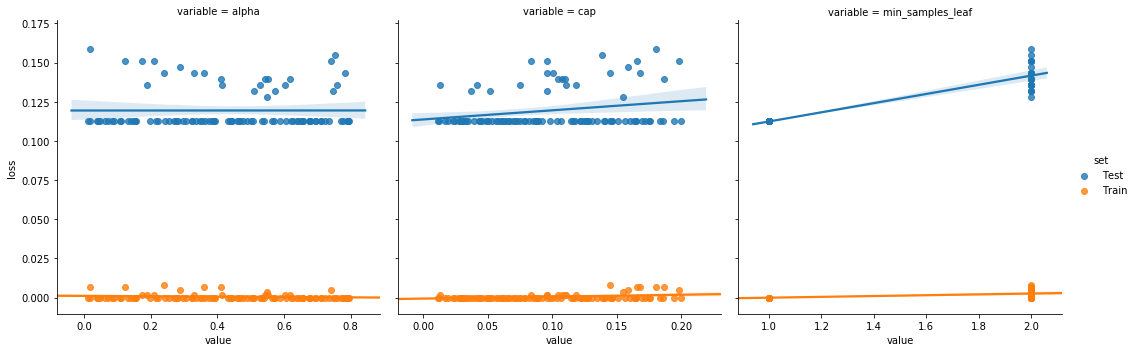

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
dd2_melted = dd2.melt(['loss', 'set'])
g = sns.lmplot(x="value", y="loss", col="variable", hue='set', data=dd2_melted,sharex=False) 

In [23]:
np.arange(0.01, 0.8)

array([0.01])

### Plot the Results
(Categorical Vars into boxplot)
This needs some fixing for the empty labels

In [ ]:
dd2_cat_melted = dd2_cat.melt(['loss', 'set'])
g = sns.catplot(x="value", y="loss", col='variable', hue='set', 
                data=dd2_cat_melted, sharex=False,
                kind='box')